In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
#path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')
path_results = Path('/media/discoD/models/elmo/jur/results_ibm')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for datalawyer_ELMo-pt+CNN_5
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_fasttext_cbow_9
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_fasttext_skip_4
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_fasttext_cbow_0
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_word2vec-lc_jur_cbow_5B-jur2vec-nilc_8
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_word2vec-lc_jur_skip_5B-jur2vec-nilc_11
metrics.json not found for datalawyer_ELMo-pt+CNN+Embeddings_word2vec-lc_jur_skip_5B-jur2vec-nilc_2
1009
1009


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAIN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, DOMAIN_SPECIFIC, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Domain_Specific',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 3:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[2]}
    elif len(data) == 4:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: True, EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], DOMAIN_SPECIFIC: True, EXECUTION_NUMBER: data[6]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    if '-pt' in data[REPRESENTATION]:
        data[MODEL] = 'datalawyer-pt'
        data[REPRESENTATION] = data[REPRESENTATION].replace('-pt', '')
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer-ft', 'ELMo', '0']
['datalawyer-ft', 'ELMo', '1']
['datalawyer-ft', 'ELMo', '10']
['datalawyer-ft', 'ELMo', '11']
['datalawyer-ft', 'ELMo', '2']
['datalawyer-ft', 'ELMo', '3']
['datalawyer-ft', 'ELMo', '4']
['datalawyer-ft', 'ELMo', '5']
['datalawyer-ft', 'ELMo', '6']
['datalawyer-ft', 'ELMo', '7']
['datalawyer-ft', 'ELMo', '8']
['datalawyer-ft', 'ELMo', '9']
['datalawyer-ft', 'ELMo+CNN', '0']
['datalawyer-ft', 'ELMo+CNN', '1']
['datalawyer-ft', 'ELMo+CNN', '10']
['datalawyer-ft', 'ELMo+CNN', '11']
['datalawyer-ft', 'ELMo+CNN', '2']
['datalawyer-ft', 'ELMo+CNN', '3']
['datalawyer-ft', 'ELMo+CNN', '4']
['datalawyer-ft', 'ELMo+CNN', '5']
['datalawyer-ft', 'ELMo+CNN', '6']
['datalawyer-ft', 'ELMo+CNN', '7']
['datalawyer-ft', 'ELMo+CNN', '8']
['datalawyer-ft', 'ELMo+CNN', '9']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '1']
['datalawyer-f

['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '1']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '10']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '11']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '2']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec-lc', 'jur', 'skip', '5B-jur2vec-nilc', '3']
['datalawyer', 'ELMo+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '0']
['datalawyer', 'ELMo+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '1']
['datalawyer', 'ELMo+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '10']
['datalawyer', 'ELMo+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '11']
['datalawyer', 'ELMo+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '2']
['da

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) < 1]
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Domain_Specific,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer-ft_ELMo_0,datalawyer-ft,ELMo,No,No,False,0,4,5,00:26:12,1572.0,314.4,0.990201,0.990597,0.897234,0.892617,0.894920,39.935539,0.987270,0.987657,0.872615,0.889590,0.881021,46.633434,0.986592,0.987099,0.867756,0.911076,0.888889,50.797832
1,datalawyer-ft_ELMo_1,datalawyer-ft,ELMo,No,No,False,1,4,5,00:26:27,1587.0,317.4,0.990072,0.990441,0.896653,0.889933,0.893280,39.944456,0.987324,0.987817,0.882568,0.889064,0.885804,46.596758,0.986032,0.986722,0.873679,0.902756,0.887980,50.931561
2,datalawyer-ft_ELMo_10,datalawyer-ft,ELMo,No,No,False,10,4,5,00:26:35,1595.0,319.0,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
3,datalawyer-ft_ELMo_11,datalawyer-ft,ELMo,No,No,False,11,4,5,00:26:34,1594.0,318.8,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
4,datalawyer-ft_ELMo_2,datalawyer-ft,ELMo,No,No,False,2,4,5,00:26:37,1597.0,319.4,0.989994,0.990391,0.894743,0.889038,0.891881,39.689800,0.987244,0.987737,0.874546,0.886961,0.880710,45.476525,0.986565,0.987164,0.871257,0.907956,0.889228,49.654239
5,datalawyer-ft_ELMo_3,datalawyer-ft,ELMo,No,No,False,3,4,5,00:26:14,1574.0,314.8,0.989966,0.990365,0.896164,0.891051,0.893600,40.184671,0.987137,0.987563,0.878772,0.888013,0.883368,46.486709,0.986006,0.986513,0.869238,0.902236,0.885430,50.938980
6,datalawyer-ft_ELMo_4,datalawyer-ft,ELMo,No,No,False,4,4,5,00:26:28,1588.0,317.6,0.989957,0.990374,0.895021,0.890716,0.892863,39.775947,0.987550,0.987990,0.878835,0.888538,0.883660,46.096697,0.986448,0.986956,0.870195,0.906396,0.887927,50.491434
7,datalawyer-ft_ELMo_5,datalawyer-ft,ELMo,No,No,False,5,4,5,00:26:24,1584.0,316.8,0.990036,0.990419,0.894885,0.890380,0.892627,39.982715,0.987204,0.987670,0.878378,0.888538,0.883429,47.215280,0.985394,0.986058,0.864204,0.900156,0.881814,52.648934
8,datalawyer-ft_ELMo_6,datalawyer-ft,ELMo,No,No,False,6,4,5,00:26:25,1585.0,317.0,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
9,datalawyer-ft_ELMo_7,datalawyer-ft,ELMo,No,No,False,7,4,5,00:26:18,1578.0,315.6,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090


In [10]:
training_data_df.to_csv('training_data_5_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:28:16.134787'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'datalawyer-ft': 'Sim', 'datalawyer': 'Não', 'datalawyer-pt': 'Geral'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor', 'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    dataframe = dataframe.rename(index={'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'})
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_datalawyer.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,360.0,88.275206,0.373287,87.127713,0.880586,0.882935,0.885093,89.149261
Não,360.0,88.254976,0.372831,86.932392,0.880363,0.883031,0.885380,89.116517
Geral,289.0,86.151611,0.752646,82.979798,0.859296,0.863083,0.866633,87.279242


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,448.0,87.797116,0.905549,84.860759,0.872667,0.881382,0.884713,89.058914
ELMo,32.0,87.654098,1.508391,84.619342,0.875002,0.884017,0.884507,88.922842
ELMo+CNN+Vetor,497.0,87.565034,1.121819,83.985056,0.866430,0.880548,0.883899,89.149261
ELMo+CNN,32.0,87.213128,1.829192,82.979798,0.868181,0.881866,0.883916,88.746803


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,404.0,87.772564,0.869962,85.648621,0.869250,0.881369,0.883786,88.996434
Sem Vetor,200.0,87.758457,1.296762,82.979798,0.868355,0.883751,0.886410,89.149261
CBoW,405.0,87.498452,1.142168,83.985056,0.868031,0.879110,0.883544,89.074778


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,68.0,87.920162,1.148249,85.362173,0.864147,0.885678,0.886410,89.149261
glove-lc,68.0,87.902489,0.938311,85.634659,0.872653,0.882427,0.886678,89.137624
Wang2Vec,136.0,87.820102,0.823078,85.987421,0.870542,0.881562,0.884713,88.956743
Word2Vec,136.0,87.811028,1.004133,85.362792,0.869032,0.882995,0.885089,89.074778
word2vec-lc,132.0,87.717562,0.930899,85.379826,0.869178,0.879817,0.883780,88.996434
wang2vec-lc,136.0,87.700762,0.909641,85.375095,0.869169,0.881382,0.883850,88.776028
FastText,133.0,87.462070,1.148142,84.213160,0.865611,0.879594,0.882203,88.877525
Sem Vetor,64.0,87.433613,1.677905,82.979798,0.869586,0.883721,0.884507,88.922842
fasttext-lc,136.0,87.299106,1.188673,83.985056,0.867915,0.877429,0.881158,88.640407


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor       Tipo de Vetor                        
Sim         ELMo+Vetor     word2vec-lc Skip-Gram          12.0  88.773392   
                           glove-lc    Sem Vetor          12.0  88.679569   
                           GloVe       Sem Vetor          12.0  88.675209   
            ELMo+CNN+Vetor GloVe       Sem Vetor          12.0  88.671218   
Não         ELMo+Vetor     wang2vec-lc CBoW               12.0  88.667611   
            ELMo+CNN+Vetor GloVe       Sem Vetor          12.0  88.667510   
Sim         ELMo+CNN+Vetor Wang2Vec    Skip-Gram          12.0  88.613565   
Não         ELMo+Vetor     word2vec-lc CBoW               12.0  88.609765   
                           Word2Vec    Skip-Gram          12.0  88.572814   
Sim         ELMo+CNN+Vetor Word2Vec    CBoW               12.0  88.547487   
            ELMo           Sem Vetor   Sem Vetor          12.0  88.544758   
Não         ELMo+Vetor     GloVe       Sem Vetor          12.0  88.542961   
Sim         ELMo+CNN+Vetor glove-lc    Sem Vetor          12.0  88.499147   
            ELMo+Vetor     Word2Vec    CBoW               12.0  88.468675   
Não         ELMo+Vetor     word2vec-lc Skip-Gram          12.0  88.467673   
            ELMo           Sem Vetor   Sem Vetor          12.0  88.460984   
            ELMo+Vetor     Wang2Vec    Skip-Gram          12.0  88.446779   
Sim         ELMo+Vetor     Wang2Vec    CBoW               12.0  88.435048   
Não         ELMo+CNN+Vetor Word2Vec    Skip-Gram          12.0  88.432001   
Sim         ELMo+Vetor     wang2vec-lc CBoW               12.0  88.418058   
Não         ELMo+CNN+Vetor Wang2Vec    Skip-Gram          12.0  88.416521   
                           glove-lc    Sem Vetor          12.0  88.374903   
                           Word2Vec    CBoW               12.0  88.363929   
            ELMo+Vetor     Word2Vec    CBoW               12.0  88.343953   
Sim         ELMo+CNN+Vetor wang2vec-lc CBoW               12.0  88.335742   
            ELMo+Vetor     Word2Vec    Skip-Gram          12.0  88.330407   
            ELMo+CNN+Vetor Word2Vec    Skip-Gram          12.0  88.327367   
Não         ELMo+CNN+Vetor fasttext-lc Skip-Gram          12.0  88.325672   
                           wang2vec-lc CBoW               12.0  88.325120   
                           FastText    Skip-Gram          12.0  88.315737   
...                                                        ...        ...   
Geral       ELMo+Vetor     Wang2Vec    Skip-Gram           8.0  86.980647   
                           glove-lc    Sem Vetor           8.0  86.928179   
                           Word2Vec    CBoW                8.0  86.906762   
                           fasttext-lc Skip-Gram           8.0  86.876049   
                           Wang2Vec    CBoW                8.0  86.646764   
                           word2vec-lc Skip-Gram           8.0  86.603950   
            ELMo+CNN+Vetor word2vec-lc Skip-Gram           9.0  86.545906   
                           Wang2Vec    CBoW               12.0  86.510181   
            ELMo+Vetor     wang2vec-lc CBoW                8.0  86.493735   
            ELMo+CNN+Vetor Wang2Vec    Skip-Gram          12.0  86.473379   
                           wang2vec-lc CBoW               12.0  86.455518   
                           Word2Vec    Skip-Gram          12.0  86.444549   
            ELMo+Vetor     FastText    Skip-Gram           8.0  86.413508   
                           Word2Vec    Skip-Gram           8.0  86.407994   
            ELMo+CNN+Vetor fasttext-lc Skip-Gram          12.0  86.393574   
            ELMo+Vetor     GloVe       Sem Vetor           8.0  86.378983   
                           wang2vec-lc Skip-Gram           8.0  86.373607   
            ELMo+CNN+Vetor word2vec-lc CBoW               11.0  86.370992   
                           wang2vec-lc Skip-Gram          12.0  86.353901   
                           glove-lc    Sem Vetor  

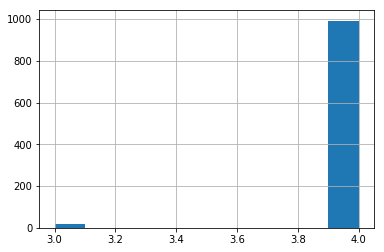

In [18]:
training_data_df[BEST_EPOCH].hist()

In [19]:
training_data_df[TOTAL_DURATION].describe()

count    1009.000000
mean     1696.134787
std        90.582067
min      1572.000000
25%      1601.000000
50%      1757.000000
75%      1775.000000
max      1998.000000
Name: Total_Duration(s), dtype: float64

In [20]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
11,73.0,0.879094,0.008888,0.845247,0.877229,0.882145,0.884713,0.890748
2,73.0,0.878931,0.010281,0.839851,0.877665,0.882548,0.884713,0.891493
8,72.0,0.878617,0.009757,0.841341,0.877315,0.881652,0.884554,0.888832
5,74.0,0.878436,0.010486,0.844802,0.876014,0.881979,0.885484,0.891165
9,89.0,0.875974,0.011057,0.829798,0.867427,0.881019,0.884253,0.889964
4,89.0,0.875913,0.011328,0.841737,0.867199,0.880753,0.884274,0.891332
0,89.0,0.875875,0.011123,0.837941,0.867225,0.880490,0.884014,0.888889
6,90.0,0.875726,0.010977,0.841159,0.867305,0.880569,0.883605,0.888889
10,90.0,0.875712,0.010963,0.843416,0.866802,0.880995,0.883851,0.888832


In [21]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,1009.0,0.876597,0.010839,0.000341,0.875928,0.877267


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,64,0.874336,0.016779,0.002097,0.870225,0.878447
fasttext,133,0.874621,0.011481,0.000996,0.872669,0.876572
fasttext-lc,136,0.872991,0.011887,0.001019,0.870993,0.874989
glove,68,0.879202,0.011482,0.001392,0.876472,0.881931
glove-lc,68,0.879025,0.009383,0.001138,0.876795,0.881255
wang2vec,136,0.878201,0.008231,0.000706,0.876818,0.879584
wang2vec-lc,136,0.877008,0.009096,0.000780,0.875479,0.878536
word2vec,136,0.878110,0.010041,0.000861,0.876423,0.879798
word2vec-lc,132,0.877176,0.009309,0.000810,0.875588,0.878764


In [23]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [24]:
print_anova(EMBEDDING)

Overall model F( 8, 1000) =  4.602, p =  0.00001570249593377093
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4.602
Date:                Wed, 10 Jul 2019   Prob (F-statistic):           1.57e-05
Time:                        17:24:54   Log-Likelihood:                 3152.3
No. Observations:                1009   AIC:                            -6287.
Df Residuals:                    1000   BIC:                            -6242.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [25]:
pd.set_option('display.max_columns', 1000)
training_data_df_2 = pd.DataFrame(training_data, columns=columns)
training_data_df_2 = training_data_df_2[training_data_df_2[DOMAIN_SPECIFIC] == True]
training_data_df_2.sort_values(by=TRAINING_ID)[TRAINING_ID,TEST_F1_MEASURE]

KeyError: ('Training_ID', 'Test_F1_Measure')